# Homework 8 - Deep Learning

Модифицируйте **TextCNN** с семинара и обучите ее на датасете IMDB. Добейтесь качества в 87% на тестовой выборке. Определим тестовую выборку следующим образом:

```python
df = pd.read_csv('IMDB Dataset.csv')
df_train, df_test = np.split(df, [45000], axis=0)
```

Модифицируйте класс датасета IMDB, чтобы он принимал датафрейм на вход, а не читал по пути.

Чтобы мы могли проверить задание, сдайте ваши предсказания для тестовой выборки (классы, считаем, что `positive = 0, negative = 1`). Для этого воспользуйтесь `torch.save`, сдайте тензор размером (5000).

## Загрузка библиотек

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import re
import os
import warnings
import string
from typing import List, Tuple
from collections import Counter

%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')

plt.rc('font', size=20)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Импорт и определение датасета

In [2]:
df = pd.read_csv('../../IMDB Dataset.csv')
df_train, df_test = np.split(df, [45000], axis=0)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [3]:
df_train

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
44995,I watched this movie for the first time a few ...,negative
44996,I am a sucker for films like this. Films that ...,positive
44997,I am a college student studying a-levels and n...,positive
44998,"huge Ramones fan. i do like the ramones, and i...",positive


In [4]:
# Создаем класс словаря
class Vocabulary:
    def __init__(self, texts: List[str], min_freq: int = 10):
        text = ' '.join(texts)

        text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", text)
        text = re.sub("[^a-zA-Z]", " ", text)

        while '  ' in text:
            text = text.replace('  ', ' ')

        words = text.strip().lower().split()

        c = Counter(words)

        self.vocabulary = list(set([word for word in words if c[word] >= min_freq]))
        self.vocabulary.append('<unk>')
        self._idx2word = {i: word for i, word in enumerate(self.vocabulary)}
        self._word2idx = {word: i for i, word in enumerate(self.vocabulary)}

    def get_vocabulary(self):
        return self.vocabulary

    def idx2word(self, idx: int):
        if idx not in self._idx2word:
            return '<unk>'

        return self._idx2word[idx]

    def word2idx(self, word: str):
        word = word.lower()
        if word not in self._word2idx:
            return self._word2idx['<unk>']

        return self._word2idx[word]
    
    def encode(self, text):
        result = []

        for word in text.split():
            result.append(self.word2idx(word))

        return result

    def build_vectors(self, fasttext):
        vectors = []
        
        for word in self.vocabulary:
            if fasttext.has_index_for(word):
                vectors.append(fasttext[word])
            else:
                vectors.append(np.zeros(25))

        return np.stack(vectors)

In [5]:
class IMDB(Dataset):
    
    def __init__(self, dataset, vocab):
        
        self.dataset = dataset
        self.vocab = vocab
        
        self.label2idx = {"positive": 0, "negative": 1}
        
    def __getitem__(self, idx):
        text = self.dataset["review"].loc[idx]
        label = self.label2idx[self.dataset["sentiment"].loc[idx]]
        
        text = torch.LongTensor(self.vocab.encode(text))
        label = torch.FloatTensor([label])
        
        return text, label
    
    def __len__(self):
        return len(self.dataset)



In [6]:
vocab = Vocabulary(df['review'].values, min_freq=5)

dataset = IMDB(df, vocab)
train_dataset = IMDB(df_train, vocab)
test_dataset = IMDB(df_test, vocab)

In [7]:
# функция для создания батчей и лоудер
from torch.nn.utils.rnn import pad_sequence

pad_idx = len(dataset.vocab.vocabulary)

def collate_fn(batch):
    texts = pad_sequence([b[0] for b in batch], padding_value=pad_idx, batch_first=True)
    labels = torch.stack([b[1] for b in batch])
    
    return texts, labels

train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=collate_fn, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn, pin_memory=True)

In [14]:
# возьмем предобученные на твиттере ембеддинги
import gensim.downloader as api

fasttext = api.load('glove-twitter-25')

vectors = dataset.vocab.build_vectors(fasttext)

[==================================================] 100.0% 104.8/104.8MB downloaded


## Служебные функции

In [21]:
def binary_accuracy(preds, y):
    y = y.cpu()
    rounded_preds = torch.round(torch.sigmoid(preds)).cpu()
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc


def train(model: nn.Module, 
                      data_loader: DataLoader, 
                      optimizer: torch.optim.Optimizer,
                      oc_scheduler,
                      loss_fn) -> Tuple[float, float, float]:
    model.to(device)
    model.train()
    lrs = []

    train_loss = 0
    train_accuracy = 0

    for x, y in tqdm(data_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()
        train_accuracy += binary_accuracy(output, y)

        loss.backward()

        optimizer.step()
        
        oc_scheduler.step()
        lrs.append(optimizer.param_groups[0]['lr'])

    train_loss /= len(data_loader)
    train_accuracy /= len(data_loader)

    return train_loss, train_accuracy, lrs


In [9]:
@torch.inference_mode()
def evaluate(model, loader, loss_fn) -> Tuple[float, float]:
    model.eval()

    total_loss = 0
    total_accuracy = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()
        total_accuracy += binary_accuracy(output, y)

    total_loss /= len(loader)
    total_accuracy /= len(loader)

    return total_loss, total_accuracy

In [10]:
def plot_stats(
    train_loss: List[float],
    valid_loss: List[float],
    train_accuracy: List[float],
    valid_accuracy: List[float],
    title: str,
    lr=None
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()
    
    if lr:
        plt.figure(figsize=(16, 8))

        plt.title(title + ' Learning Rate')
        plt.plot(lr, label='Learning Rate')
        plt.grid()

        plt.show()

In [70]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []
    lr_history = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy, lrs = train(model, 
                                                                   train_loader,
                                                                   optimizer,
                                                                   oc_scheduler,
                                                                   loss_fn)
        valid_loss, valid_accuracy = evaluate(model, test_loader, loss_fn)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)
        lr_history.extend(lrs)


        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title, lr_history
        )
    

## Модель

In [104]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, pad_idx):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        self.convs = nn.ModuleList(
            [
                nn.Conv2d(
                    in_channels = 1, 
                    out_channels = 16, 
                    kernel_size = (fs, embedding_dim)) 
                for fs in range(2, 2 + 16)
            ]
        )

        self.fc = nn.Linear(16 * 16, 1)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]

        x = [F.max_pool1d(_, _.shape[2]).squeeze(2) for _ in x]

        x = self.dropout(torch.cat(x, dim = 1))

        return self.fc(x)

In [105]:
model = TextCNN(vocab_size=len(dataset.vocab.vocabulary) + 1, embedding_dim=25, pad_idx=pad_idx)


In [106]:

loss_fn = nn.BCEWithLogitsLoss()

optimizer = Adam(model.parameters(), lr=1e-3)

oc_scheduler = OneCycleLR(optimizer=optimizer, max_lr=0.01,
                          epochs=10, steps_per_epoch=len(train_loader))

In [107]:
model.embedding.weight.data[:len(vectors)] = torch.from_numpy(vectors)

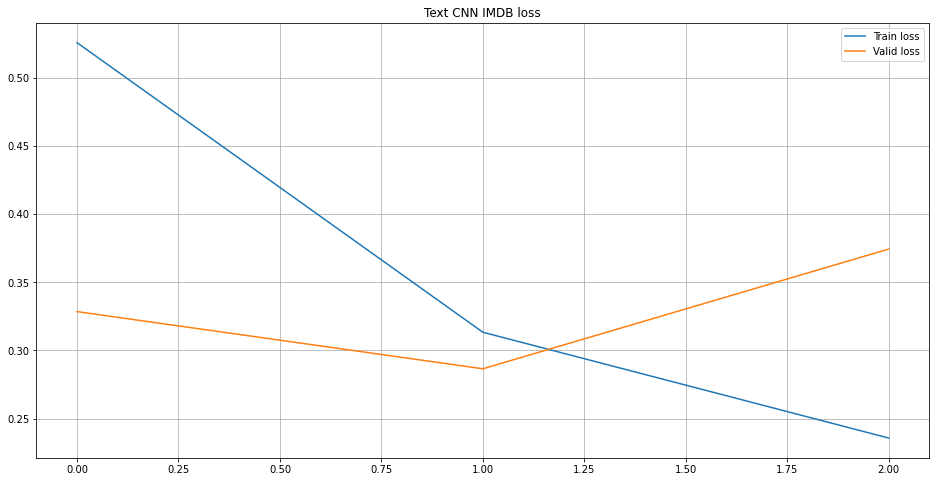

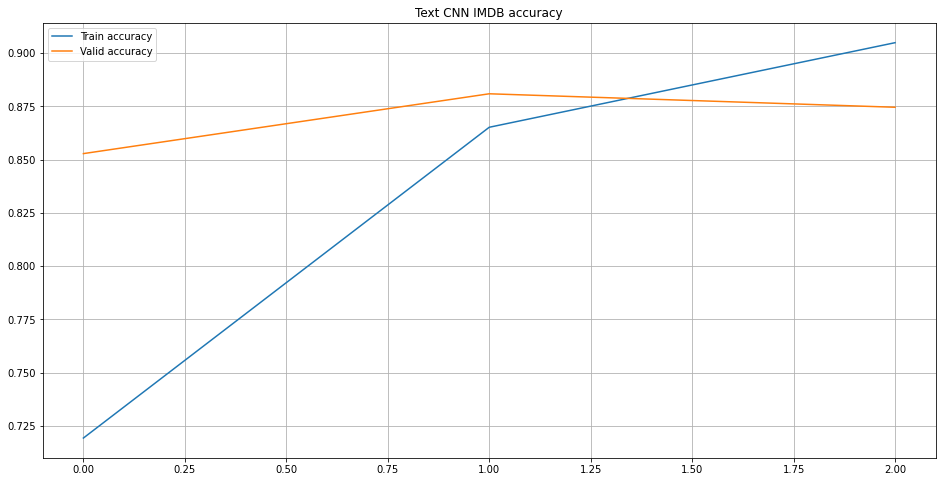

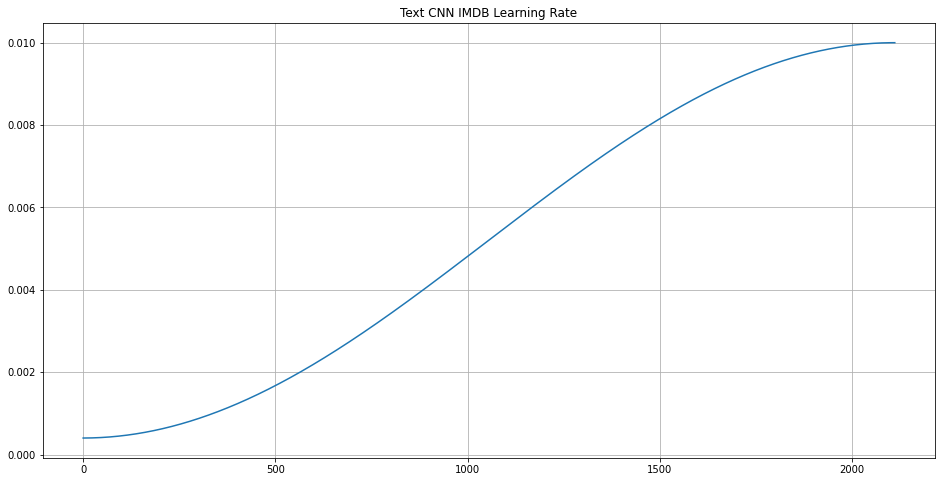

Train:   6%|▋         | 44/704 [00:08<02:03,  5.36it/s]


KeyboardInterrupt: 

In [108]:
whole_train_valid_cycle(model, 10, 'Text CNN IMDB')

In [109]:
@torch.inference_mode()
def predict(model: nn.Module, loader: DataLoader, device: torch.device):
    model.eval()
    preds = []

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        output = model(x)

        rounded_preds = torch.round(torch.sigmoid(output)).cpu()

        preds.append(rounded_preds)

    return torch.cat(preds)


In [110]:
test = predict(model, test_loader, device)


In [111]:
torch.save(test.reshape([5000]), 'hw8.pt')
